<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor

In [2]:
# загрузим данные и сделаем индексом столбец с датой, приведя его к формату дат
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
# посмотрим на первые пять строк
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
# посмотрим на размер
data.shape

(26496, 1)

In [6]:
# посморим на пропуски
data.isna().sum() 

num_orders    0
dtype: int64

In [7]:
# проверим, в хронологическом ли порядке расположены даты и время
data.index.is_monotonic

True

In [8]:
# проверим на повторы
data.index.is_unique  

True

**В данных 26496 строк, один столбец с датой с интервалом 10 минут (его мы сделали индексом) и один с количеством вызовов. Пропусков в данных нет, расположены в хронологическом порядке, повторов нет.**

## Анализ

In [9]:
# выполним ресемплирование по одному часу, т.к. предсказания нам нужны на следующий час
data = data.resample('1H').sum()

In [10]:
# проверим преобразования
display(data.head())
data.info()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


Text(0.5, 1.0, 'Количество заказов такси по часам')

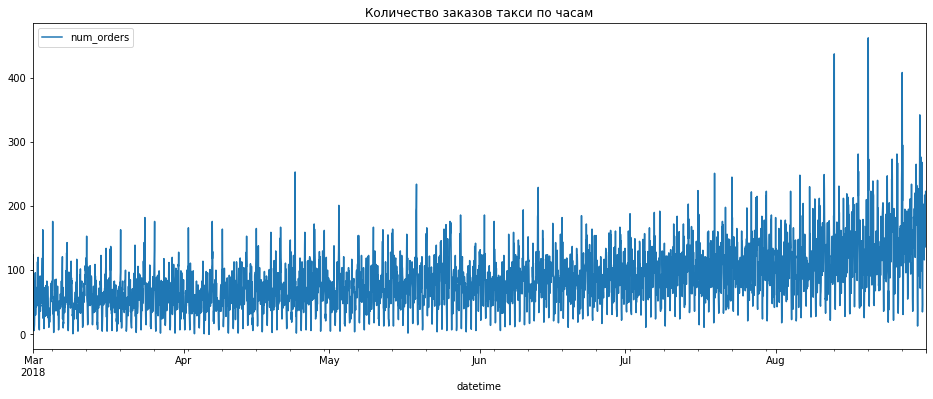

In [11]:
data.plot(figsize = (16,6))
plt.title("Количество заказов такси по часам")

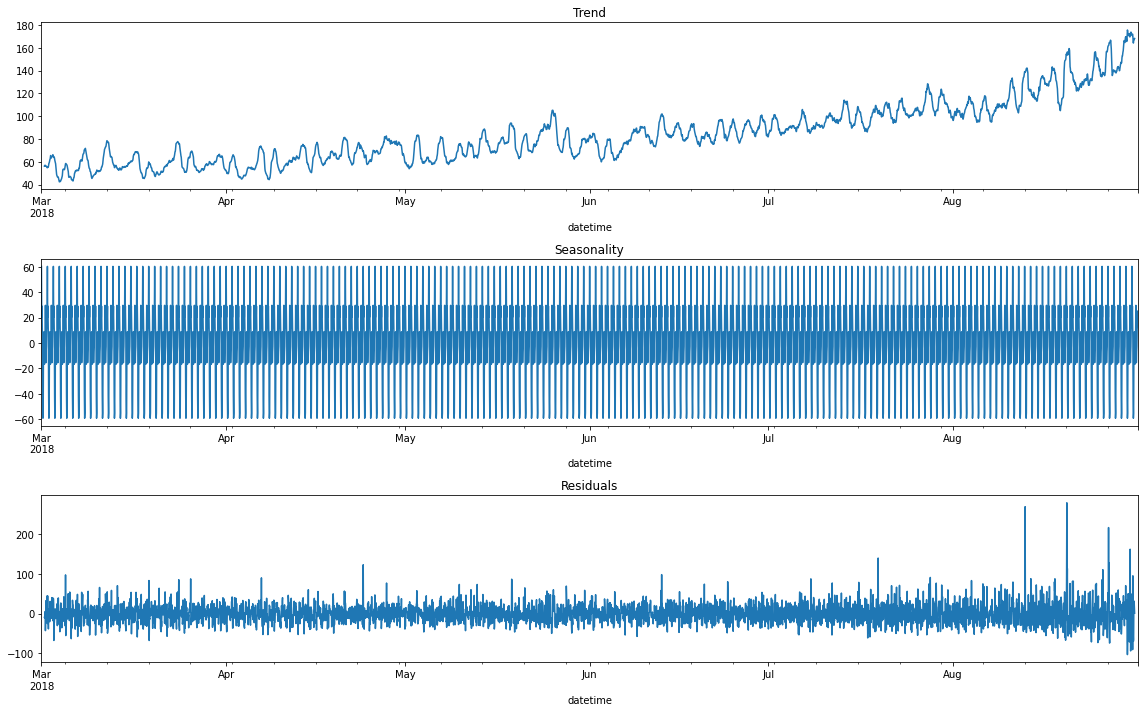

In [12]:
# построим графики тренда, сезонности и график шума
decomposed = seasonal_decompose(data)

plt.figure(figsize=(16, 10))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его оси ax, равными plt.gca() 
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot() 
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Text(0.5, 1.0, 'График сезонности количества заказов такси за месяц')

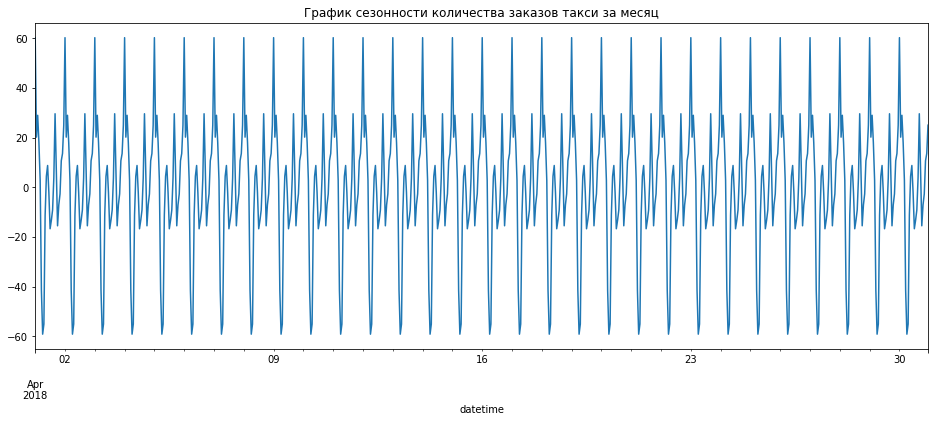

In [13]:
# возьмем меньший диапозон (месяц), чтобы увидеть шаг сезонности
decomposed.seasonal['2018-04-01':'2018-04-30'].plot(figsize = (16,6))
plt.title("График сезонности количества заказов такси за месяц")

Text(0.5, 1.0, 'График сезонности количества заказов такси за неделю')

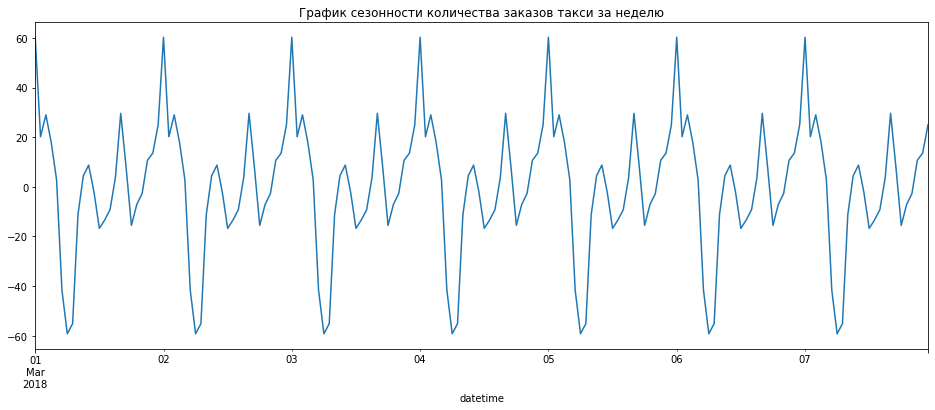

In [14]:
# возьмем ущё меньший диапозон - неделю
decomposed.seasonal['2018-03-01':'2018-03-07'].plot(figsize = (16,6))
plt.title("График сезонности количества заказов такси за неделю")

Text(0.5, 1.0, 'Количество заказов такси со скользящиим средним в разрезе недели')

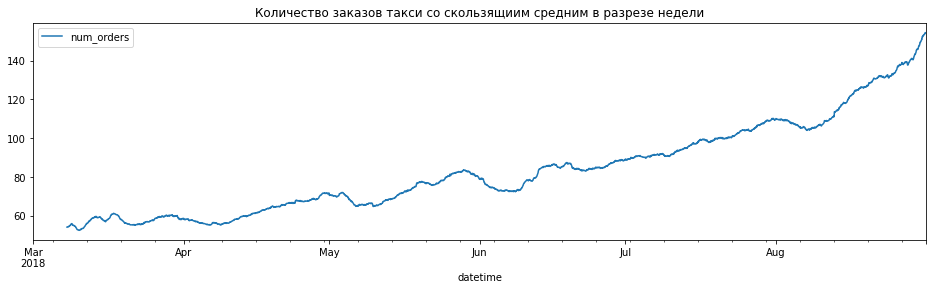

In [15]:
# построим график со скользящим средним отклонением в разрезе недели (24*7)
data.rolling(168).mean().plot(figsize = (16,4))
plt.title("Количество заказов такси со скользящиим средним в разрезе недели")

Text(0.5, 1.0, 'Распределение скользящего стандартного отклонения')

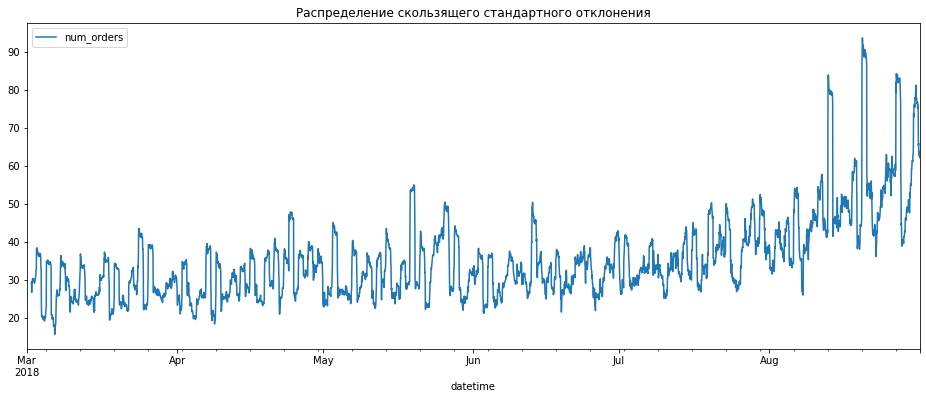

In [16]:
# построим график распределения скользящего стандартного отклонения 
data.rolling(24).std().plot(figsize = (16,6))
plt.title("Распределение скользящего стандартного отклонения")

**В первоначальных данных интервал был 10 минут, мы сгруппировали по 1 часу. Согласно графикам у нас наблюдается положительный тренд, а сезонность и недельная и суточная. Распределение скользящего среднего отклонения меняется, значит процесс не совсем стационарный.**

In [17]:
# код ревьювера
from statsmodels.tsa.stattools import adfuller

taxi = pd.read_csv("/datasets/taxi.csv", index_col=[0], parse_dates=[0]).resample('1H').sum()

ts = taxi['num_orders']
st_test = adfuller(ts, regression='ctt')

print('Если значение с индексом 1 меньше P-Value, заданное нами (обычно берут 0.05), то ряд стационарный')
if st_test[1] < 0.05:
    print('Наш ряд стационарный')
else:
    print('Ряд нестационарный')




Если значение с индексом 1 меньше P-Value, заданное нами (обычно берут 0.05), то ряд стационарный
Наш ряд стационарный


## Обучение

In [18]:
# Создадим признаки для горизонта прогнозирования (год нам не нужен, у нас период полгода, месяц тоже, у нас нет этой сезонности) 
# признаки отстающих значений (предыдущие значения временного ряда покажут, будет ли расти ф-ия x(t) расти или уменьшаться)
# признак скользящего среднего (задаст общий тренд временного ряда)
def make_features(data, max_lag, rolling_mean_size):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

In [19]:
# отстающие значения - 24, так как есть явно выраженная суточная сезонность, скользящее среднее-неделя для покрытия колебаний 
data = make_features(data, 24, 7)

In [20]:
data.head()

,num_orders,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,1,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,1,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,1,3,66.0,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
# разделим выборки, удалим строки с пропусками в признаках и проверим хронологию
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-02 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


In [22]:
# выделим целевой признак
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']
print(features_train.shape)
features_test.shape

(3950, 27)


(442, 27)

In [23]:
# Чтобы при кросс-валидации избежать ситуации, когда тренировочная выборка будет позже валидационной, 
# будем применять TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

**Градиентный бустинг CatBoostRegressor**

In [24]:
model = CatBoostRegressor(loss_function="RMSE", depth=5, iterations=20)

scores = cross_val_score(model, features_train, target_train, scoring='neg_root_mean_squared_error', cv=tscv) 

print('Средняя оценка качества модели:', scores.mean()*-1)

Learning rate set to 0.5
0:	learn: 24.5156031	total: 49.8ms	remaining: 946ms
1:	learn: 22.2370437	total: 51.9ms	remaining: 468ms
2:	learn: 20.8623007	total: 54.1ms	remaining: 307ms
3:	learn: 19.6243228	total: 56.2ms	remaining: 225ms
4:	learn: 19.0428264	total: 58.3ms	remaining: 175ms
5:	learn: 18.2115499	total: 60.6ms	remaining: 141ms
6:	learn: 17.7687797	total: 63ms	remaining: 117ms
7:	learn: 17.1631112	total: 65.1ms	remaining: 97.7ms
8:	learn: 16.8847829	total: 67.5ms	remaining: 82.4ms
9:	learn: 16.6045464	total: 69.8ms	remaining: 69.8ms
10:	learn: 16.1424535	total: 71.9ms	remaining: 58.9ms
11:	learn: 15.8635170	total: 74.2ms	remaining: 49.5ms
12:	learn: 15.7199083	total: 76.5ms	remaining: 41.2ms
13:	learn: 15.5273280	total: 78.6ms	remaining: 33.7ms
14:	learn: 15.2232916	total: 80.9ms	remaining: 27ms
15:	learn: 14.7976477	total: 83.2ms	remaining: 20.8ms
16:	learn: 14.5120846	total: 85.2ms	remaining: 15ms
17:	learn: 14.0404674	total: 87.4ms	remaining: 9.71ms
18:	learn: 13.6719647	tota

**Случайный лес регрессии RandomForestRegressor с оптимизацией гиперпараметров с помощью поиска по сетке**

In [25]:
rfr_space={
    'max_depth': range(4, 40, 2),
    'n_estimators':range(10, 250, 30)
}
rfr = RandomForestRegressor(random_state=12345)

rfr_random = RandomizedSearchCV(rfr,
                                rfr_space,
                                n_iter=4,
                                scoring='neg_root_mean_squared_error',
                                cv=tscv,
                                error_score='raise')

rfr_model = rfr_random.fit(features_train, target_train)

rmse = rfr_model.best_score_*-1

print(f'Лучшие параметры: {rfr_model.best_params_}')

print(f'Лучшая точность: {rmse}')

Лучшие параметры: {'n_estimators': 190, 'max_depth': 38}
Лучшая точность: 25.686799174268156


**Градиентный бустинг над решающими деревьями LGBMRegressor с оптимизацией гиперпараметров с помощью случайного поиска**

In [26]:
%%time 
# Найдем наилучшую комбинацию гиперпараметров через GridSearchCV
parameters_grid_lgbm = {
    'n_estimators': range(80, 100, 10),
    'boosting_type': ['gbdt']   
}
lgbm = LGBMRegressor(random_state=12345)
 
lgbm_model_cv = GridSearchCV(lgbm, 
                            param_grid=parameters_grid_lgbm,
                            scoring = 'neg_root_mean_squared_error', 
                            cv = tscv, 
                            error_score='raise')

lgbm_model_cv.fit(features_train, target_train)

print(f'Лучшая точность: {(-1)*round(lgbm_model_cv.best_score_, 3)}')
print(f'Лучшая модель: {lgbm_model_cv.best_estimator_}') 
print(f'Лучшие параметры: {lgbm_model_cv.best_params_}') 

Лучшая точность: 25.565
Лучшая модель: LGBMRegressor(n_estimators=90, random_state=12345)
Лучшие параметры: {'boosting_type': 'gbdt', 'n_estimators': 90}
CPU times: user 16.7 s, sys: 94.3 ms, total: 16.8 s
Wall time: 16.9 s


## Тестирование

**Лучший результат показала модель RandomForestRegressor, её и проверим на тесте**

In [27]:
prediction = rfr_random.predict(features_test)
rmse_rfr = mean_squared_error(target_test, prediction, squared=False)
print('Точность rmse модели RandomForestRegressor:', rmse_rfr)

Точность rmse модели RandomForestRegressor: 42.43889458027305


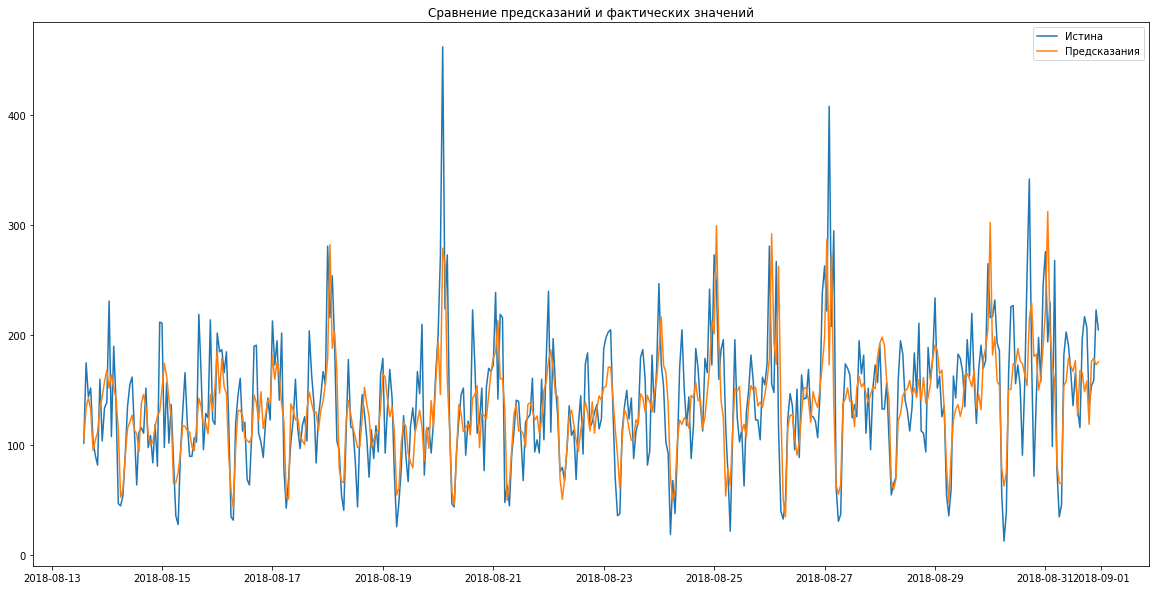

In [28]:
plt.figure(figsize=(20,10))

plt.plot(target_test, label='Истина')
plt.plot(target_test.index, prediction, label='Предсказания')

plt.title('Сравнение предсказаний и фактических значений')
plt.legend();

**Модель чаще ошибается на пиковых значениях.** 

**Вывод: проанализированы исторические данные о заказах такси в аэропортах, выполнено их ресемплирование по одному часу. Согласно проведенного анализа у нас наблюдается положительный тренд, а сезонность и недельная и суточная. Распределение скользящего среднего отклонения меняется, значит процесс не совсем стационарный. Нестационарные ряды прогнозировать сложнее. Для прогнозирования количество заказов такси на следующий час проверены модели: Градиентный бустинг CatBoostRegressor, случайный лес регрессии RandomForestRegressor с оптимизацией гиперпараметров с помощью поиска по сетке, градиентный бустинг над решающими деревьями LGBMRegressor с оптимизацией гиперпараметров с помощью случайного поиска. Выбрана лучшая модель RandomForestRegressor, значение метрики RMSE на тестовой выборке получено 42,58.**

In [29]:
# проверка модели на адекватность
pred_previous = target_test.shift()
pred_previous.iloc[0] = target_train.iloc[-1]
print("RMSE:", mean_squared_error(target_test, pred_previous)** 0.5)

RMSE: 58.856486242815066
